# Measuring centroids and position angles for the LoVoCCS sample

Here we measure the centroid coordinate and position angle of the intra-cluster medium X-ray emission of the LoVoCCS sample. The centroid is the first moment of the 2D surface brightness distribution (the average position, weighted by the surface brightness) and acts as an alternate (to the peak) definition of the central coordinate - it is also useful when combined with the peak, allowing for the creation of a metric for cluster disturbedness (a word I suspect I just made up).

The second moment of the 2D surface brightness distribution is essentially the covariance matrix, which can then be diagonalised to find the rotation angle (which can be turned into a position angle) and the axis length ratio of the (assumed) ellipse that describes the ICM emission.

## Import Statements

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from astropy.units import Quantity, UnitConversionError
from astropy.cosmology import LambdaCDM
from shutil import rmtree
import os
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse, FancyArrow

import xga
xga.NUM_CORES = 5
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample

# This is a bit cheeky, but suppresses the warnings that XGA spits out (they are 
#  useful, but not when I'm trying to present this notebook on GitHub)
import warnings
warnings.filterwarnings('ignore')

# Set up a variable that controls how long individual XSPEC fits are allowed to run
timeout = Quantity(6, 'hr')

%matplotlib inline

## Setting up necessary directories

Here we ensure that the directories we need to store the outputs in have been created:

In [260]:
if not os.path.exists("../../outputs/figures/positions/centroid_dists/fix_ap_error_dist/"):
    os.makedirs("../../outputs/figures/positions/centroid_dists/fix_ap_error_dist/")
    
if not os.path.exists("../../outputs/figures/positions/centroid_dists/multi_ap_centroid_dist/"):
    os.makedirs("../../outputs/figures/positions/centroid_dists/multi_ap_centroid_dist/")
    
if not os.path.exists("../../outputs/coordinates"):
    os.makedirs("../../outputs/coordinates/")
    
if not os.path.exists("../../outputs/cluster_visualisations/centroid_posangle_meas/"):
    os.makedirs("../../outputs/cluster_visualisations/centroid_posangle_meas/")

## Defining any useful functions

Specifically, this is where we define the function that measures the centroid coordinate and the position angle of the ICM distribution - this will be included into XGA at some point, but for now we use this function:

In [263]:
def centroid_shape_estimate(rel_src, ap_rad, cent_coord=None, log_data=False, num_samp=100):
    
    # TODO BACKGROUND SUBTRACTION
    
    
    
    cur_rt = src.get_combined_ratemaps()
    cont_mask = src.get_interloper_mask()
    
    if ap_rad is not None:
        ap_mask = src.get_custom_mask(ap_rad, remove_interlopers=False, central_coord=cent_coord)
    else:
        ap_mask = np.ones(cur_rt.shape)
        
    tot_mask = ap_mask*cont_mask
    
    data_cp = cur_rt.data.copy()
    if not log_data:
        msk_data = data_cp*tot_mask
    else:
        msk_data = np.log10(data_cp*tot_mask)
        msk_data[np.isinf(msk_data)] = 0
    
    norm_data = msk_data / msk_data.sum()
    
    arr_x, arr_y = np.meshgrid(np.arange(0, norm_data.shape[1], ), np.arange(0, norm_data.shape[0]))
    
    x_cen_pix = (norm_data*arr_x).sum()
    y_cen_pix = (norm_data*arr_y).sum()
    cen_pix = [x_cen_pix, y_cen_pix]
    cen_pix_quan = Quantity(cen_pix, 'pix')
    
    covar = np.zeros((2, 2))
    covar[0, 0] = (norm_data*np.square(arr_x - cen_pix[0])).sum()
    covar[1, 1] = (norm_data*np.square(arr_y - cen_pix[1])).sum()
    covar[0, 1] = (norm_data * (arr_x - cen_pix[0]) * (arr_y - cen_pix[1])).sum()
    covar[1, 0] = covar[0, 1]
    
    # TODO Try to normalise this output + ensure that it is North of East (does my head in)
    theta = 0.5*np.arctan((2*covar[1, 0]) / (covar[0, 0]-covar[1, 1]))*(180/np.pi)
    mod_theta = theta % 360
    if ((covar[1, 0] > 0 and (covar[0, 0] - covar[1, 1]) < 0) or 
            (covar[1, 0] < 0 and (covar[0, 0] - covar[1, 1]) < 0)):
        mod_theta = mod_theta - 90
    
    # This turns it (hopefully) from an angle defined from the usual axis (which matplotlib takes as an
    #  angle argument for its ellipse patch) to a position angle defined east from north
    mod_theta = mod_theta - 90
    
    eig_pl = ((covar[0, 0] + covar[1, 1]) + np.sqrt((covar[0, 0] - covar[0, 0])**2 + 4*covar[0, 1]**2)) / 2
    eig_mi = ((covar[0, 0] + covar[1, 1]) - np.sqrt((covar[0, 0] - covar[0, 0])**2 + 4*covar[0, 1]**2)) / 2

    x_s = np.sqrt(eig_pl)
    y_s = np.sqrt(eig_mi)
    
    # If the number of re-samples requested is zero, we end the function here and return (did it like this 
    #  because many of the bits of math using the resampled cov matrix are long and indenting them further 
    #  does not sound like fun)
    if num_samp == 0:
        return cur_rt.coord_conv(cen_pix_quan, 'deg'), mod_theta, x_s, y_s, None, None, None, None
    
    rng = np.random.default_rng()
    resamp_msk_data = np.repeat((data_cp*cont_mask)[:, :, np.newaxis], num_samp, axis=2)*tot_mask[..., None]
    resamp_msk_data = rng.poisson(resamp_msk_data*cur_rt.expmap.data[..., None])/cur_rt.expmap.data[..., None]
    resamp_msk_data[np.isnan(resamp_msk_data)] = 0
    
    resamp_norm_data = resamp_msk_data / resamp_msk_data.sum(axis=(0, 1))
    
    x_cen_pix_resamp_dist = (resamp_norm_data*arr_x[..., None]).sum(axis=(0, 1))
    y_cen_pix_resamp_dist = (resamp_norm_data*arr_y[..., None]).sum(axis=(0, 1))
    cen_pix_resamp_dist = Quantity([x_cen_pix_resamp_dist, y_cen_pix_resamp_dist], 'pix').T
    cen_deg_resamp_dist = cur_rt.coord_conv(cen_pix_resamp_dist, 'deg')
    
    
    resamp_covar = np.zeros((2, 2, num_samp))
    
    resamp_covar[0, 0, :] = (resamp_norm_data*np.square(arr_x[..., None] - 
                                                        cen_pix_resamp_dist[:, 0].value)).sum(axis=(0, 1))
    resamp_covar[1, 1, :] = (resamp_norm_data*np.square(arr_y[..., None] - 
                                                        cen_pix_resamp_dist[:, 1].value)).sum(axis=(0, 1))
    
    resamp_covar[0, 1, :] = ((resamp_norm_data*(arr_x[..., None] - cen_pix_resamp_dist[:, 0].value)*
                              (arr_y[..., None] - cen_pix_resamp_dist[:, 1].value)).sum(axis=(0, 1)))
    resamp_covar[1, 0, :] = resamp_covar[0, 1, :]
    
    theta_dist = (0.5*np.arctan((2*resamp_covar[1, 0, :]) / 
                                (resamp_covar[0, 0, :]-resamp_covar[1, 1, :]))*(180/np.pi))
    mod_theta_dist = theta_dist % 360
    
    rot_bool = (((resamp_covar[1, 0, :] > 0) & ((resamp_covar[0, 0, :] - resamp_covar[1, 1, :]) < 0)) | 
                ((resamp_covar[1, 0, :] < 0) & ((resamp_covar[0, 0, :] - resamp_covar[1, 1, :]) < 0)))
    mod_theta_dist = mod_theta_dist - (np.full(num_samp, 90)*rot_bool)
    
    mod_theta_dist = mod_theta_dist - 90
    
    eig_pl_dist = (((resamp_covar[0, 0, :] + resamp_covar[1, 1, :]) + 
                    np.sqrt((resamp_covar[0, 0, :] - resamp_covar[0, 0, :])**2 + 4*resamp_covar[0, 1, :]**2)) / 2)
    eig_mi_dist = (((resamp_covar[0, 0, :] + resamp_covar[1, 1, :]) - 
                    np.sqrt((resamp_covar[0, 0, :] - resamp_covar[0, 0, :])**2 + 4*resamp_covar[0, 1, :]**2)) / 2)
    
    x_s_dist = np.sqrt(eig_pl_dist)
    y_s_dist = np.sqrt(eig_mi_dist)
    
    return cur_rt.coord_conv(cen_pix_quan, 'deg'), mod_theta, x_s, y_s, cen_deg_resamp_dist, mod_theta_dist, \
        x_s_dist, y_s_dist

## Reading in the sample

We read in the LoVoCCS sample relevant to the current work:

In [4]:
samp = pd.read_csv("../../sample_files/X-LoVoCCSI.csv")
samp['LoVoCCS_name'] = samp['LoVoCCSID'].apply(lambda x: "LoVoCCS-" + str(x))
samp

,LoVoCCSID,Name,start_ra,start_dec,MCXC_Redshift,MCXC_R500,MCXC_RA,MCXC_DEC,manual_xray_ra,manual_xray_dec,LoVoCCS_name
0,1,A2029,227.734300,5.745471,0.0766,1.3344,227.73000,5.720000,227.734300,5.745471,LoVoCCS-1
1,2,A401,44.740000,13.580000,0.0739,1.2421,44.74000,13.580000,NaN,NaN,LoVoCCS-2
2,4,A85,10.458750,-9.301944,0.0555,1.2103,10.45875,-9.301944,NaN,NaN,LoVoCCS-4
3,5,A3667,303.157313,-56.845978,0.0556,1.1990,303.13000,-56.830000,303.157313,-56.845978,LoVoCCS-5
4,7,A3827,330.480000,-59.950000,0.0980,1.1367,330.48000,-59.950000,NaN,NaN,LoVoCCS-7
...,...,...,...,...,...,...,...,...,...,...,...
61,121,A3128,52.466189,-52.580728,0.0624,0.8831,52.50000,-52.600000,52.466189,-52.580728,LoVoCCS-121
62,122,A1023,157.000000,-6.800000,0.1176,0.8553,157.00000,-6.800000,NaN,NaN,LoVoCCS-122
63,123,A3528,193.670000,-29.220000,0.0544,0.8855,193.67000,-29.220000,NaN,NaN,LoVoCCS-123
64,131,A761,137.651250,-10.581111,0.0916,0.8627,137.65125,-10.581111,NaN,NaN,LoVoCCS-131


## Defining an XGA ClusterSample

As we do not have observation cleaning turned on, we manually remove clusters that we know are excluded from our other analyses due to inadequate XMM data:

* LoVoCCS-41C is a component of 41 we identified from ROSAT Pointed data, but it does not fall on the XMM observation.
* LoVoCCS-33 is a cluster that partially falls on the edge of an observation of a nearby object - the coverage is insufficient for any real analysis however.

In [5]:
samp = samp[~samp['LoVoCCSID'].isin(['41C', '33'])]

We define a ClusterSample, centered on the 'start positions' we defined in the early stages of our analysis of this sample - the start positions will be the same as the MCXC positions in cases where we judged the coordinate to be adequate, but will be manually defined from modern observations if it was too far outside the main part of the ICM, or if the cluster has multiple components that went unresolved in MCXC:

In [6]:
srcs = ClusterSample(samp['start_ra'].values, samp['start_dec'].values, samp['MCXC_Redshift'].values, 
                     samp['LoVoCCS_name'].values, r500=Quantity(samp['MCXC_R500'].values, 'Mpc'), use_peak=False, 
                     clean_obs=False)
srcs.info()

Setting up Galaxy Clusters:  33%|███▎      | 20/61 [01:32<01:41,  2.48s/it]

ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division
Setting up Galaxy Clusters: 100%|██████████| 61/61 [03:18<00:00,  3.25s/it]


-----------------------------------------------------
Number of Sources - 61
Redshift Information - True
Sources with ≥1 detection - 59 [97%]
-----------------------------------------------------



## Measuring centroid & PA within a fixed aperture

First of all, we measure the centroid position within a fixed aperture that is centered on the 'start coordinate'. Any identified contaminating sources are removed, to try to avoid biasing the position. As a part of this analysis, we also measure the position angle and the axis ratio of the ellipse. 

Then, visualisations are generated (saved to disk in the 'outputs' section of this repository) and displayed (for a small subset to avoid making this notebook file too large). The centroid position is indicated by the solid cross-hair, and the start position by the dashed cross-hair; the white ellipse indicates the axis sizes (though it has been arbitrarily scaled up in size, the ratio of the axis lengths is the most useful thing), as well as its rotation.

We also attempt to quantify the statistical uncertainty on the quantities we measure here by resampling the count-rate map many times to produce posterior distributions of the properties - these are then used to calculate uncertainties (and the distribution histograms are saved to disk):

LoVoCCS-1


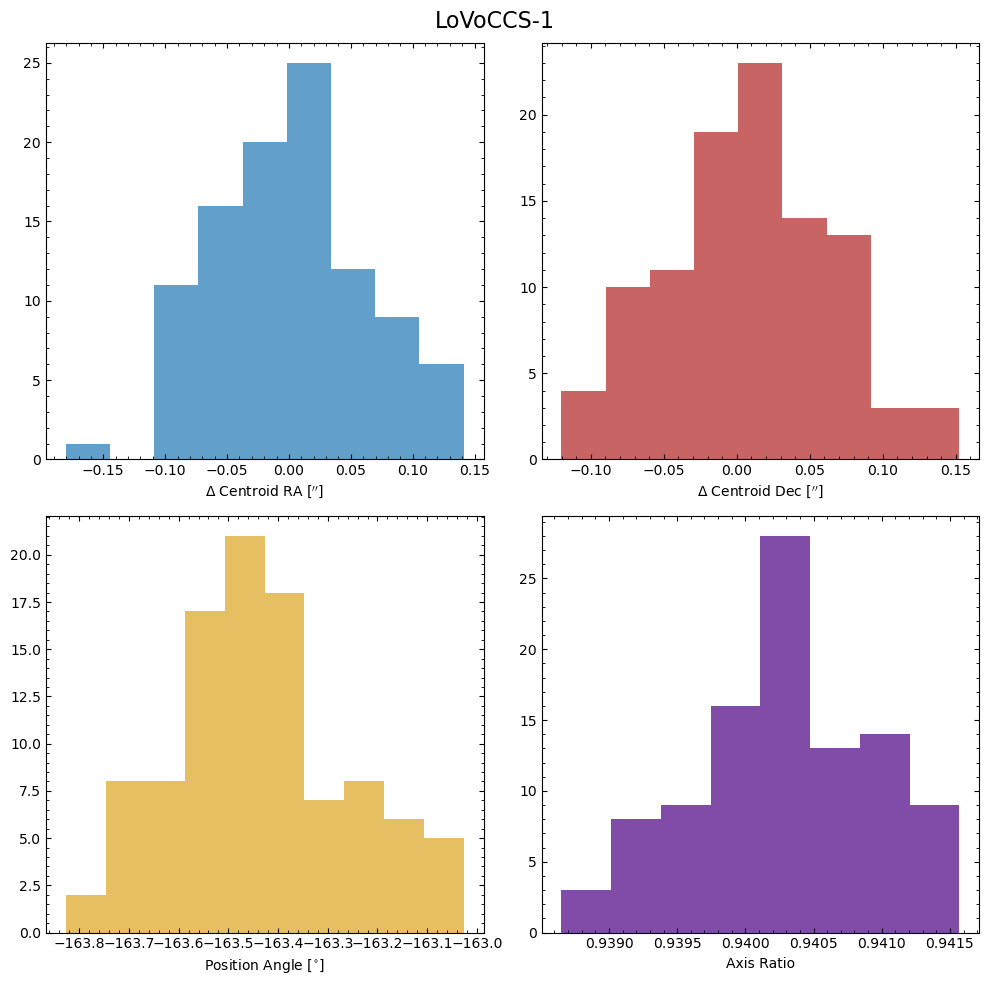

LoVoCCS-2


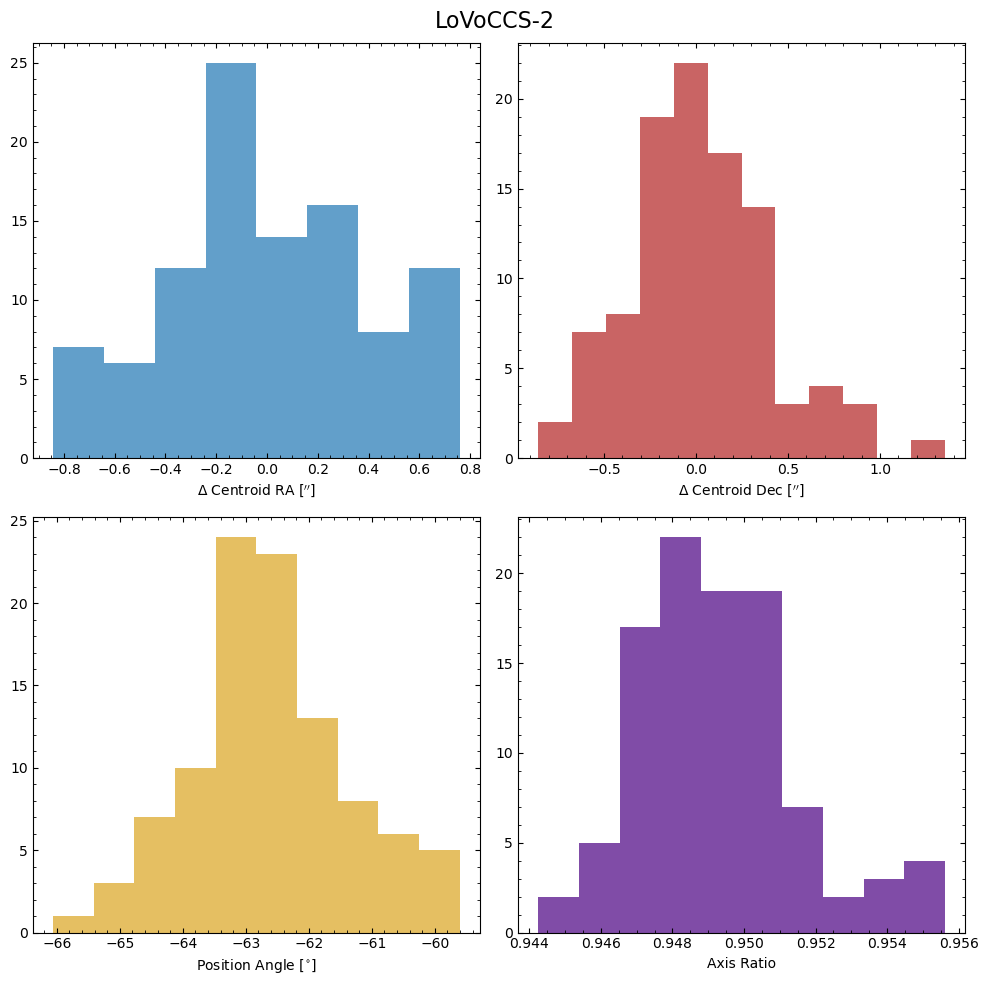

LoVoCCS-4


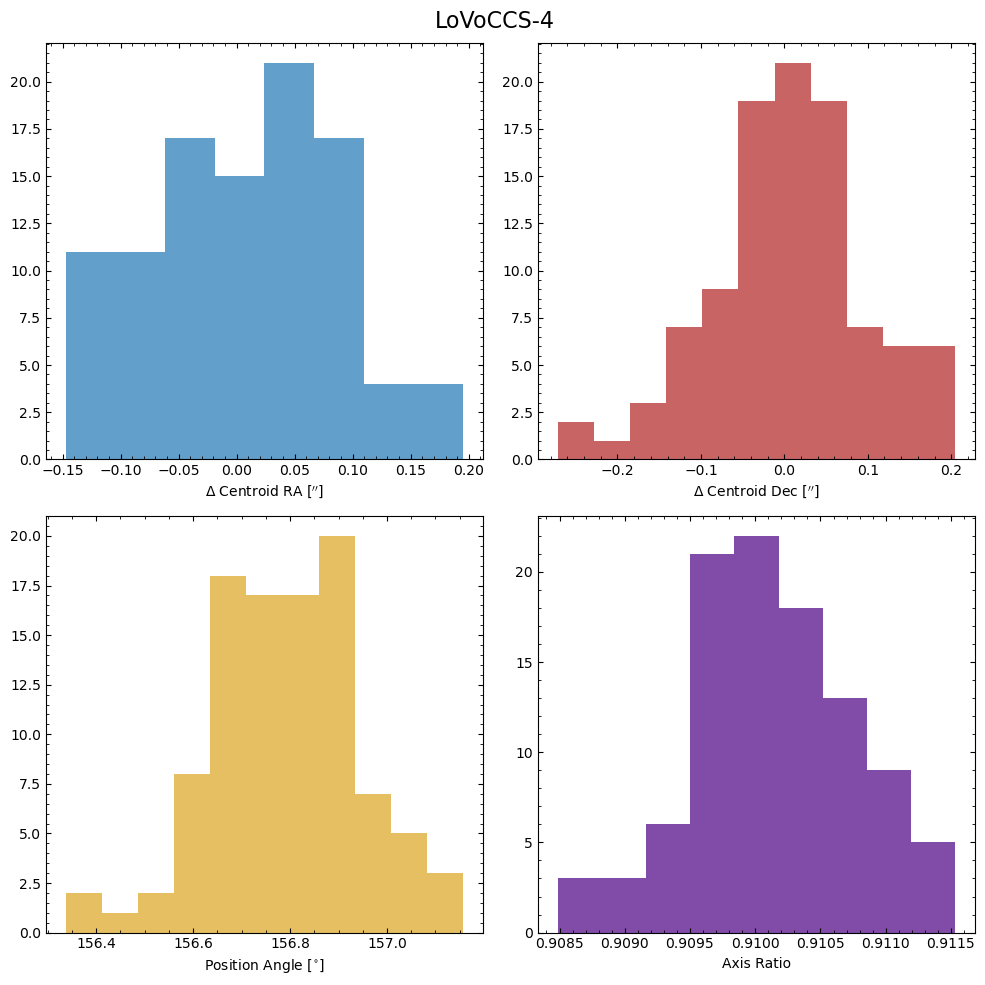

LoVoCCS-5


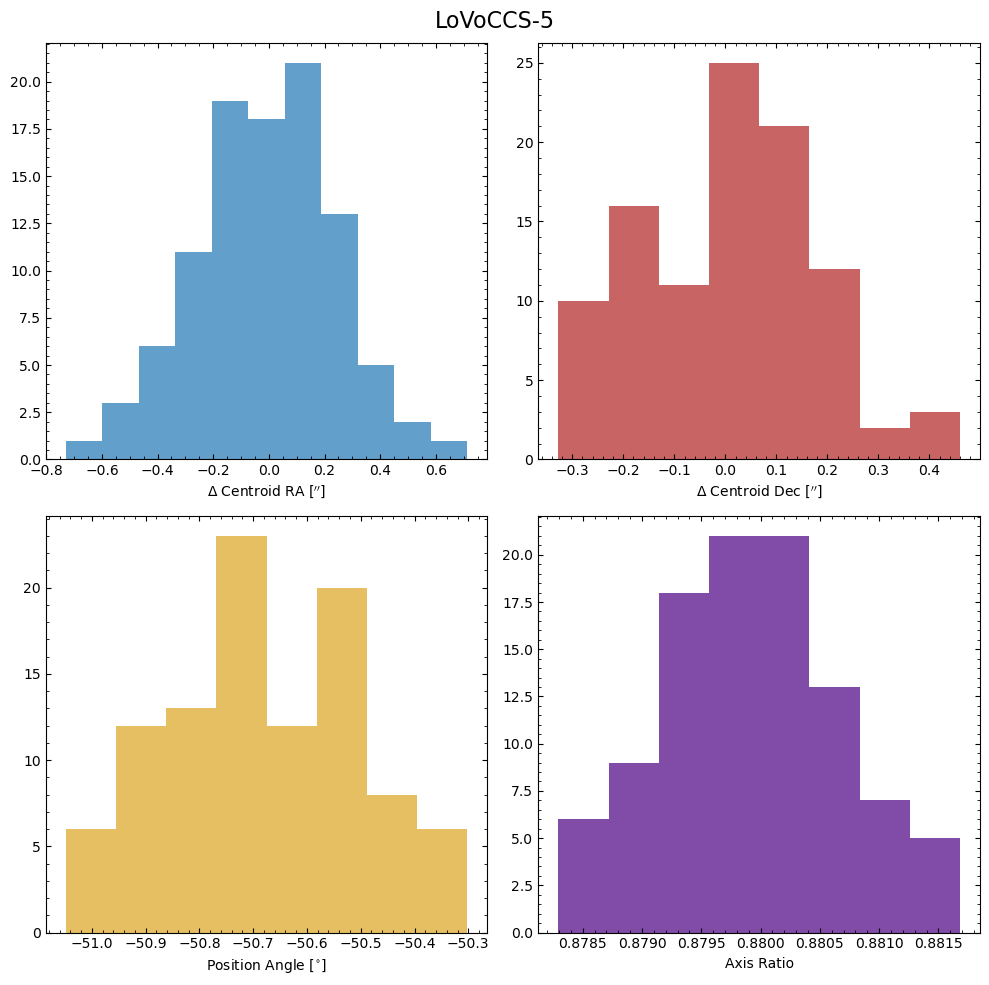

LoVoCCS-7


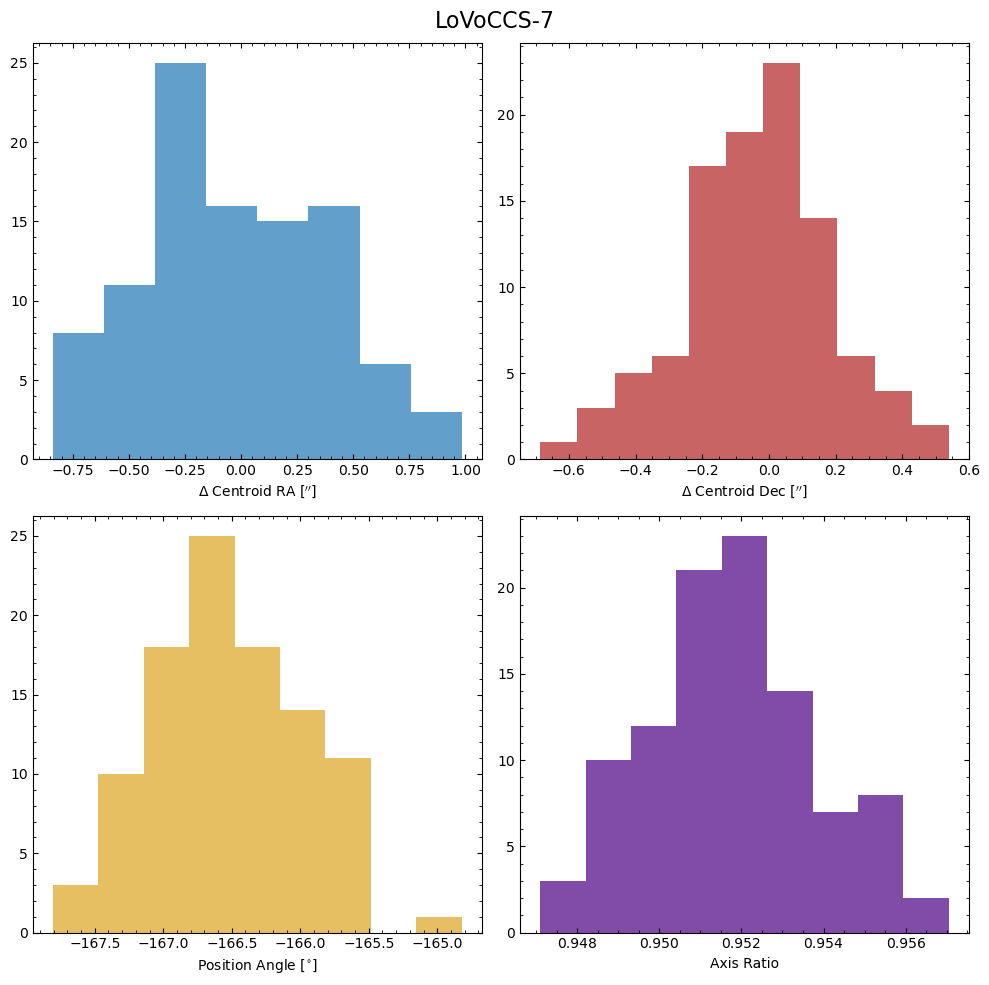

LoVoCCS-9


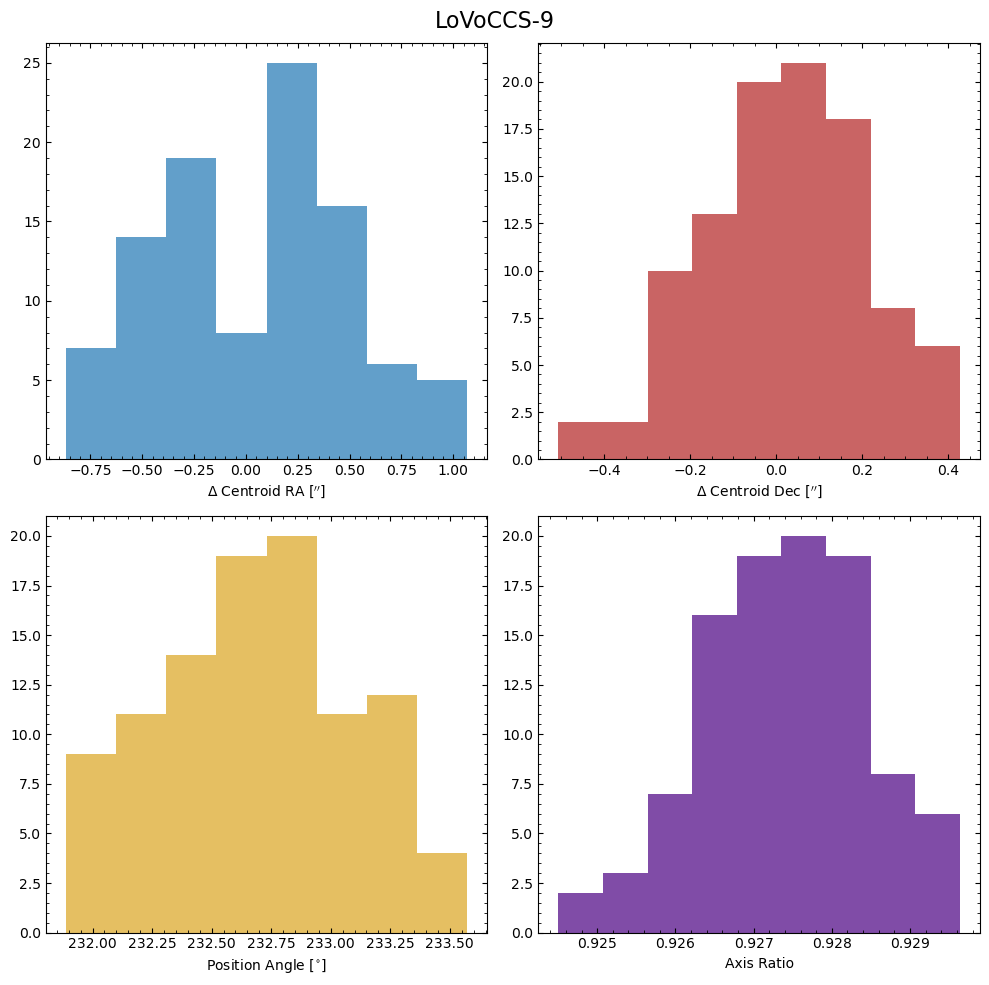

LoVoCCS-10


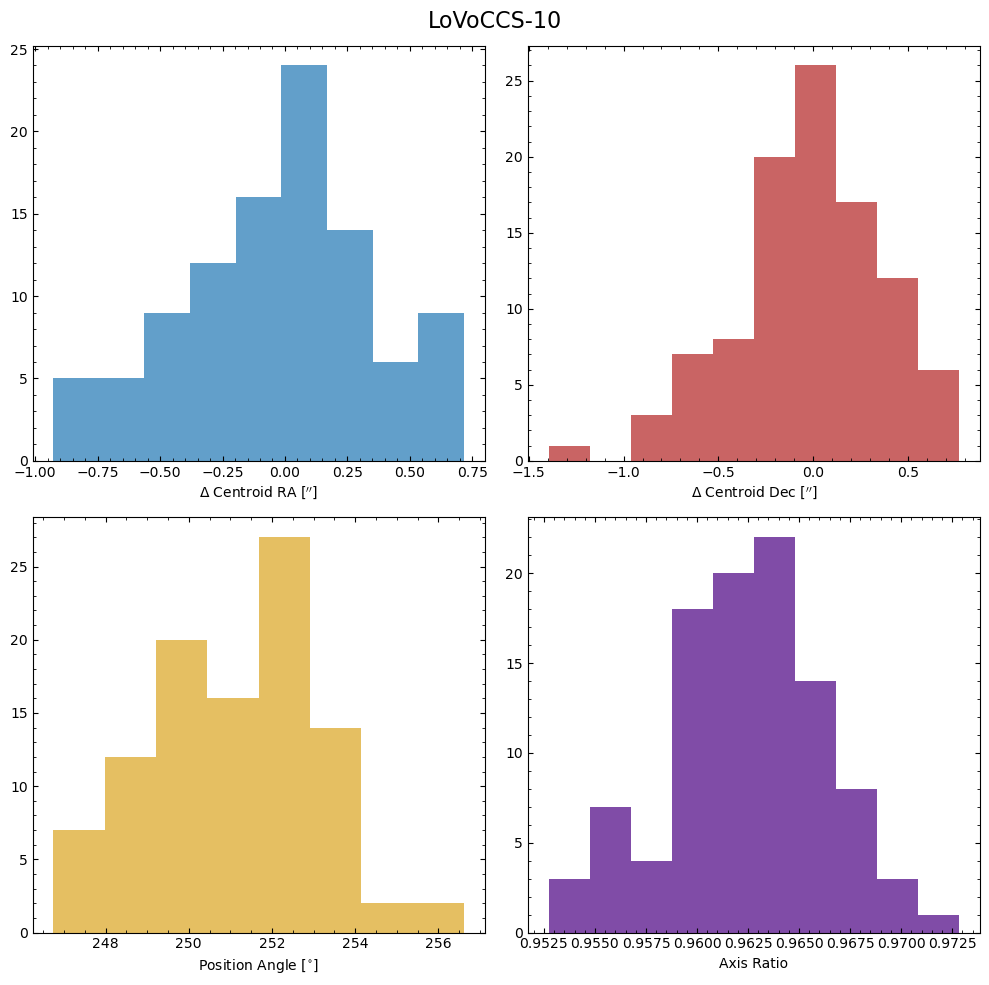

LoVoCCS-11


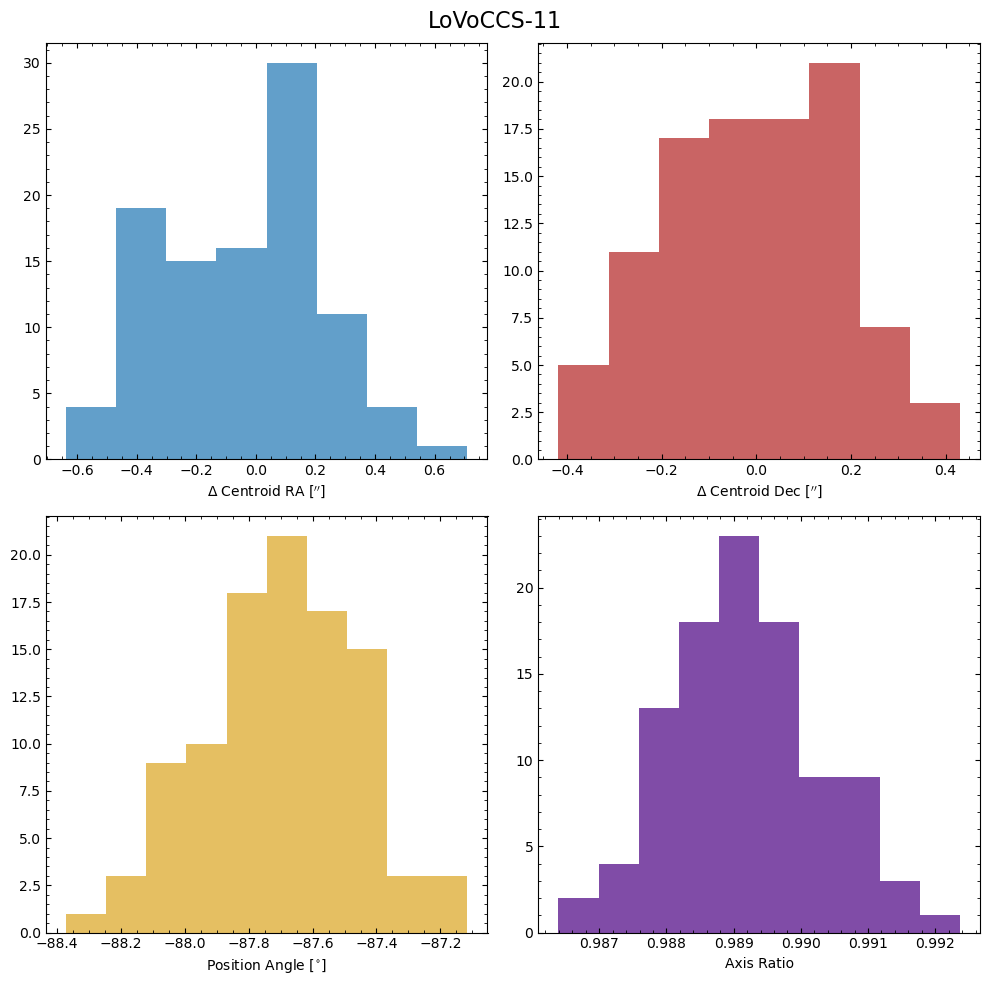

LoVoCCS-12


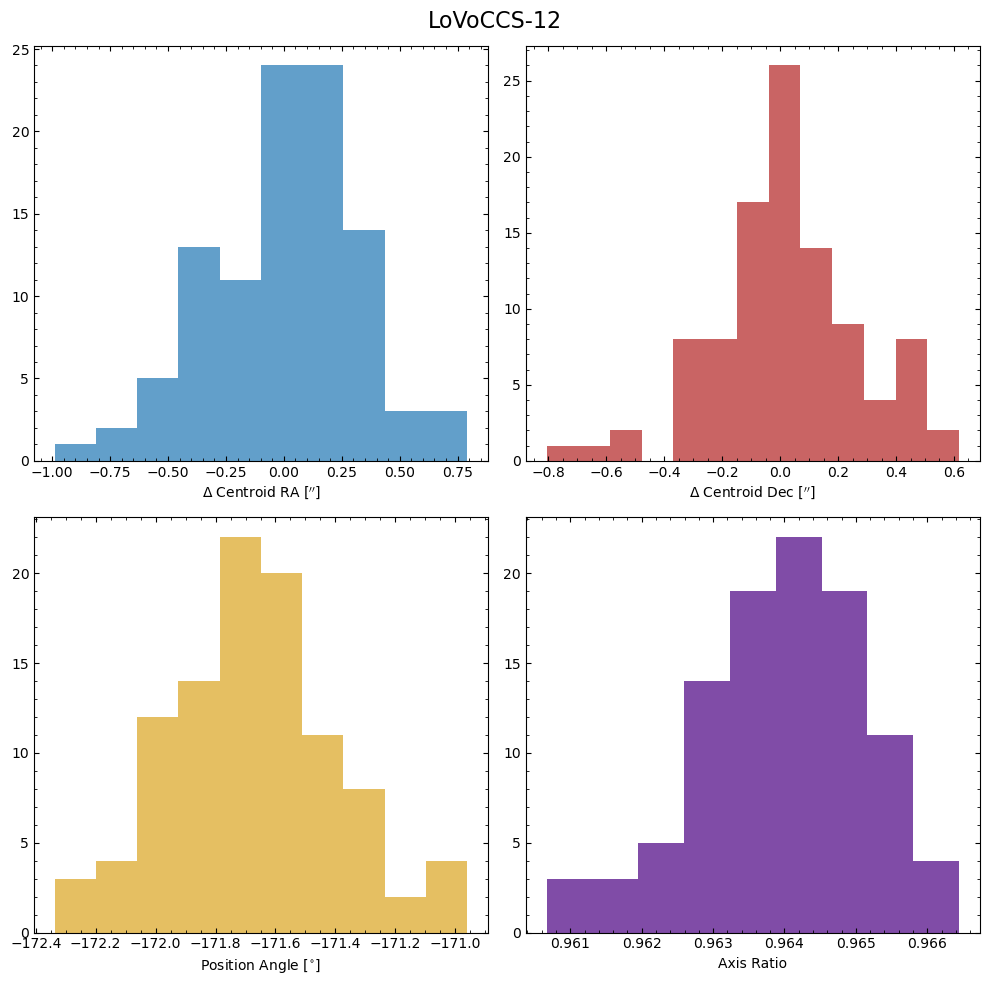

LoVoCCS-13


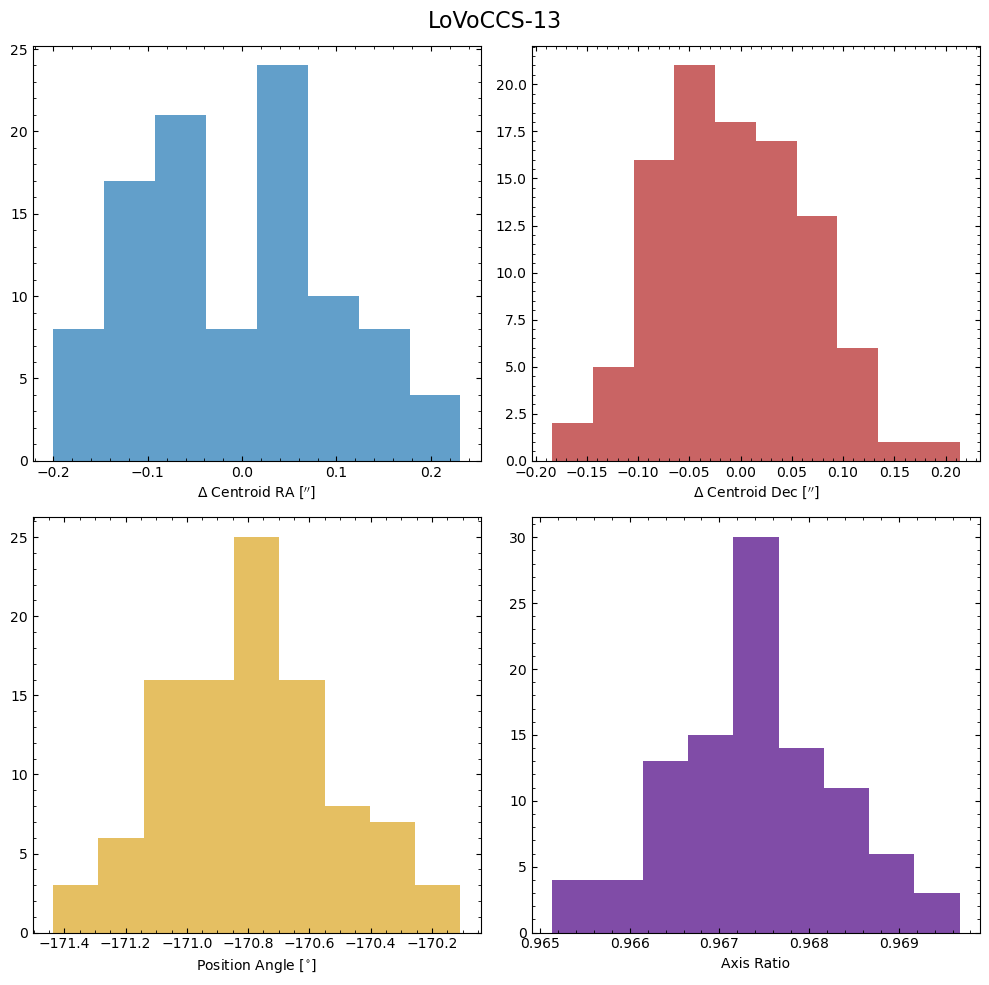

ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


In [262]:
# The fixed aperture we're using
ap = Quantity(500, 'kpc')
# This defines the number of times the count-rate map is resampled to calculate the statistical uncertainties
resamp = 100
# The confidence level for the extracted uncertainties
conf_level = 90

# We store our fixed-aperture measurements of centroid coordinate, position angle, and axis lengths here
fixed_ap_ra = {}
fixed_ap_dec = {}
fixed_ap_ang = {}
fixed_ap_rat = {}

# Iterating through all of our sources
for src_ind, src in enumerate(srcs):
    # This runs the centroid/PA calculation function defined near the top of the notebook. The returned position
    #  is in degrees, the PA should be defined East of North. We also return distributions of central coords, 
    #  position angle, and x/y scale, calculated from the resampled count-rate maps (the resamp variable defined
    #  how many there are)
    cur_cen, cur_pa, cur_x_scale, cur_y_scale, cur_cen_dist, cur_pa_dist, cur_x_scale_dist, \
        cur_y_scale_dist = centroid_shape_estimate(src, ap, num_samp=resamp) 
    
    # We can calculate confidence levels from the distributions of RA and Dec
    cen_fiftieth = np.percentile(cur_cen_dist, 50, axis=0).to('deg')
    cen_pl = np.percentile(cur_cen_dist, 50 + (conf_level/2), axis=0).to('deg') - cen_fiftieth
    cen_mi = cen_fiftieth - np.percentile(cur_cen_dist, 50 - (conf_level/2), axis=0).to('deg')

    # Same deal with the position angle, we calculate the upper and lower uncertainties at the specified
    #  confidence level 
    # TODO Some angles are degenerate and we get huge uncertainties (I suspect) - sort it 
    pa_fiftieth = np.percentile(cur_pa_dist, 50, axis=0)
    pa_pl = np.percentile(cur_pa_dist, 50 + (conf_level/2), axis=0) - pa_fiftieth
    pa_mi = pa_fiftieth - np.percentile(cur_pa_dist, 50 - (conf_level/2), axis=0)
    
    # Create distribution of axis ratios from the x and y scale distributions 
    rat_dist = np.min(np.array([(cur_x_scale_dist / cur_y_scale_dist), (cur_y_scale_dist / cur_x_scale_dist)]), 
                      axis=0)
    # Then we calculate the uncertainties the same way
    rat_fiftieth = np.percentile(rat_dist, 50, axis=0)
    rat_pl = np.percentile(rat_dist, 50 + (conf_level/2), axis=0) - rat_fiftieth
    rat_mi = rat_fiftieth - np.percentile(rat_dist, 50 - (conf_level/2), axis=0)
    
    # Store the results of this analysis in dictionaries for later
    fixed_ap_ra[src.name] = [cur_cen[0], cen_mi[0], cen_pl[0]]
    fixed_ap_dec[src.name] = [cur_cen[1], cen_mi[1], cen_pl[1]]
    fixed_ap_ang[src.name] = [cur_pa, pa_mi, pa_pl]
    fixed_ap_rat[src.name] = [min([(cur_x_scale/cur_y_scale), (cur_y_scale/cur_x_scale)]), rat_mi, rat_pl]
    
    # We make some crude histograms of the output distributions of the different values we've measured, so
    #  they aren't lost forever - they will be saved to disk as well
    fig, ax_arr = plt.subplots(2, 2, figsize=(10, 10))
    
    for ax_ind, ax in np.ndenumerate(ax_arr):
        ax.minorticks_on()
        ax.tick_params(which='both', direction='in', top=True, right=True)
    
    # We just plot the histograms, nothing fancy - we also leave the bins to auto
    ax_arr[0, 0].hist((cur_cen_dist[:, 0]-cur_cen[0]).to("arcsec").value, bins='auto', 
                      histtype='stepfilled', label='RA', color='tab:blue', alpha=0.7)
    ax_arr[0, 0].set_xlabel(r"$\Delta$ Centroid RA [$^{\prime\prime}$]")
    
    ax_arr[0, 1].hist((cur_cen_dist[:, 1]-cur_cen[1]).to("arcsec").value, bins='auto', 
                      histtype='stepfilled', label='Dec', color='firebrick', alpha=0.7)
    ax_arr[0, 1].set_xlabel(r"$\Delta$ Centroid Dec [$^{\prime\prime}$]")
    
    ax_arr[1, 0].hist(cur_pa_dist, bins='auto', histtype='stepfilled', label='PA', 
                      color='goldenrod', alpha=0.7)
    ax_arr[1, 0].set_xlabel(r"Position Angle [$^{\circ}$]")
    
    ax_arr[1, 1].hist(rat_dist, bins='auto', histtype='stepfilled', label='Axis Ratio', 
                      color='indigo', alpha=0.7)
    ax_arr[1, 1].set_xlabel(r"Axis Ratio")
    
    # Add an overall title containing the name of the cluster
    plt.suptitle(src.name, fontsize=16)
    plt.tight_layout()
    # All histograms are saved
    file_name = "{n}_xmm_centroid_{a}kpc_prop_dists.pdf".format(n=src.name, a=ap.to('kpc').value.astype(int))
    plt.savefig("../../outputs/figures/positions/centroid_dists/fix_ap_error_dist/" + file_name)
    # Only the first ten are shown here, to keep the size of the notebook down
    if src_ind < 10: 
        print(src.name)  
        plt.show()
    plt.close('all')
    
    # Fetch the combined ratemap
    cur_rt = src.get_combined_ratemaps()
    
    # Start constructing the visualisation
    plt.figure(figsize=(8, 8))
    ax = plt.gca()
    # We use the 'get_view' method here to return the axis populated with our nicely formatted ratemap data (as 
    #  well as with centroid as solid cross-hair and start position as dashed cross-hair), and then we will
    #  add to it.
    cur_rt.get_view(ax, Quantity([cur_cen, src.ra_dec]))
    
    # Convert the centroid position to pixels, so we use it to define an ellipse to overplot
    cur_cen_pix = cur_rt.coord_conv(cur_cen, 'pix')
    # The ellipse is set up using the pixel centre, abritrarily scaled up x and y axis lengths (the ratio
    #  of them is more useful than the actual values honestly), and the position angle (+90 to return to the 
    #  convention required by Matplotlib)
    scale_fac = 5
    ell = Ellipse(cur_cen_pix.value, cur_x_scale*scale_fac, cur_y_scale*scale_fac, cur_pa + 90, fc='none', 
                  ec='white')
    ax.add_patch(ell)
    
    # Here we wish to add a line along the major axis of the ellipse, to unambiguously indicate the rotation
    #  angle we measured. We separate the arrow into two halves, as we're not yet sure whether this figure is 
    #  clearer with a full major axis or just a semi-major axis line.
    # This sets the width of the actual line
    line_width = 0.2
    # We also set the alpha here
    alpha = 0.8
    
    # Simply use the parametrisation of an ellipse to calculate dx and dy from the center
    line_stop_dx = ((cur_x_scale/2)*scale_fac)*np.cos((cur_pa + 90)*(np.pi/180))
    line_stop_dy = ((cur_y_scale/2)*scale_fac)*np.sin((cur_pa + 90)*(np.pi/180))
    # Setup the patch with our start and end coords, as well as the appearance settings
    line = FancyArrow(*cur_cen_pix.value, line_stop_dx, line_stop_dy, color='white', head_width=8, 
                      length_includes_head=True, overhang=0.7, width=line_width, alpha=alpha)
    # Then add the patch
    ax.add_patch(line)
    
    # Repeat the process but flipped 180 degrees
    line_stop_dx = ((cur_x_scale/2)*scale_fac)*np.cos((cur_pa + 90 + 180)*(np.pi/180))
    line_stop_dy = ((cur_y_scale/2)*scale_fac)*np.sin((cur_pa + 90 + 180)*(np.pi/180))
    line = FancyArrow(*cur_cen_pix.value, line_stop_dx, line_stop_dy, color='white', head_width=8,
                      length_includes_head=True, overhang=0.7, width=line_width, alpha=alpha)
    ax.add_patch(line)
    
    plt.tight_layout()
    
    # All visualisations are saved to disk
    file_name = "{n}_xmm_centroid_{a}kpc_search_vis.pdf".format(n=src.name, a=ap.to('kpc').value.astype(int))
    plt.savefig("../../outputs/cluster_visualisations/centroid_posangle_meas/" + file_name)
    
    # We only display a few visualisations, in order to avoid making the Jupyter Notebook too large 
    #  to be rendered by the GitHub website
    if src_ind < 10:
        plt.show()
    plt.close('all')

### Saving the fixed aperture centroids, angles, and axis ratios

Here we construct a save file containing the just measured centroid positions, angles, and axis ratios (though we measured some form of axis length, its actual physical meaning is limited, the axis ratios are more directly useful).

In [246]:
# Somewhat overkill, but I still remember the days of unordered dictionaries in Python and I remain paranoid, 
#  this reads the centroid positions into a single quantity (easier to add to a dataframe)
out_ras = Quantity([Quantity(fixed_ap_ra[n]) for n in srcs.names]).round(5)
out_decs = Quantity([Quantity(fixed_ap_dec[n]) for n in srcs.names]).round(5)
out_angs = np.array([fixed_ap_ang[n] for n in srcs.names]).round(4)
out_ax_rat = np.array([fixed_ap_rat[n] for n in srcs.names]).round(4)

out_data = np.concatenate([srcs.names[..., None], out_ras.value, out_decs.value, out_angs, out_ax_rat], 
                          axis=1)
out_cols = ['LoVoCCS_name', 'cent_ra', 'cent_ra-', 'cent_ra+', 'cent_dec', 'cent_dec-', 'cent_dec+', 
            'position_angle', 'position_angle-', 'position_angle+', 'ax_ratio', 'ax_ratio-', 'ax_ratio+']
out_df = pd.DataFrame(out_data, columns=out_cols)

file_name = "xmm_{a}kpc_centroid.csv".format(n=src.name, a=ap.to('kpc').value.astype(int))
out_df.to_csv("../../outputs/coordinates/" + file_name, index=False)
out_df

,LoVoCCS_name,cent_ra,cent_ra-,cent_ra+,cent_dec,cent_dec-,cent_dec+,position_angle,position_angle-,position_angle+,ax_ratio,ax_ratio-,ax_ratio+
0,LoVoCCS-1,227.7333,3e-05,2e-05,5.7434,3e-05,3e-05,-163.4614,0.2405,0.2468,0.9403,0.0009,0.0012
1,LoVoCCS-2,44.73672,0.00016,0.00015,13.57758,0.00017,0.00014,-62.4765,2.2318,2.6154,0.9492,0.0045,0.0044
2,LoVoCCS-4,10.4603,3e-05,3e-05,-9.30429,4e-05,4e-05,156.7758,0.1846,0.2407,0.9101,0.0008,0.0009
3,LoVoCCS-5,303.14496,0.00015,0.00014,-56.83985,6e-05,6e-05,-50.688,0.2846,0.2392,0.88,0.0015,0.001
4,LoVoCCS-7,330.47892,0.00018,0.00015,-59.94837,0.0001,0.00011,-166.5197,1.0998,0.8525,0.9517,0.0032,0.0043
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,LoVoCCS-119,125.25834,6e-05,8e-05,7.86434,0.0001,7e-05,-81.2119,2.5813,3.1456,0.9892,0.0039,0.0035
57,LoVoCCS-121,52.47763,0.00045,0.00033,-52.58026,0.00021,0.00019,171.0752,7.5786,7.2651,0.9946,0.0049,0.0043
58,LoVoCCS-123,193.67501,0.00027,0.00034,-29.22703,0.00025,0.0003,149.7445,1.6379,1.6312,0.9248,0.0063,0.0054
59,LoVoCCS-131,137.65137,0.00047,0.00042,-10.5825,0.00046,0.00042,261.2762,2.3737,2.9209,0.9619,0.0105,0.0129


## Effect of different apertures

Here we perform the centroid calculation within a variety of different apertures, to give us some impression of how much the aperture affects the centroid coordinate - this is essentially the process required to measure centroid shift, but here we measure with more apertures, at fixed scales (not physically defined by $R_{500}$), and calculate the difference between the centroid and the **start** position - later in the notebook we will perform the centroid shift calculation using much the same technique.

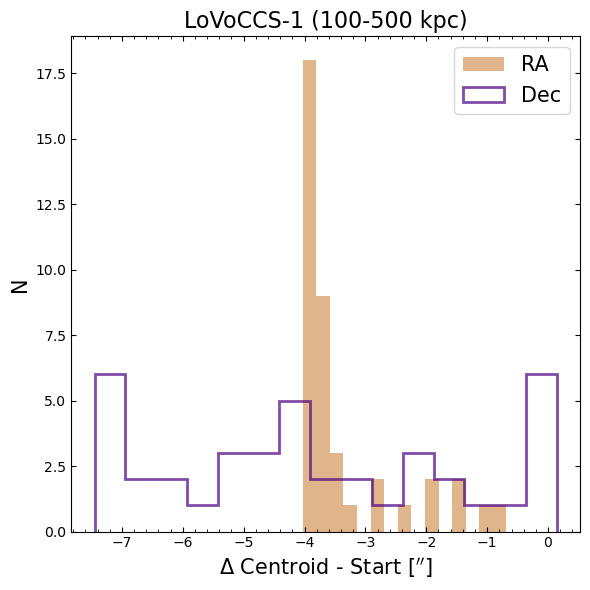

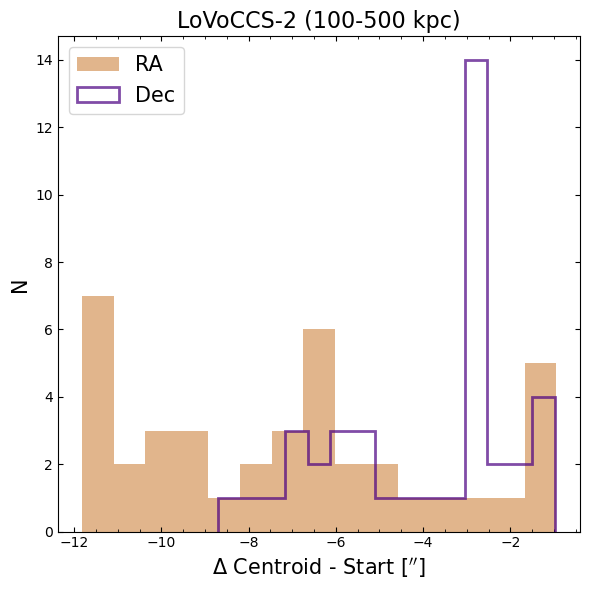

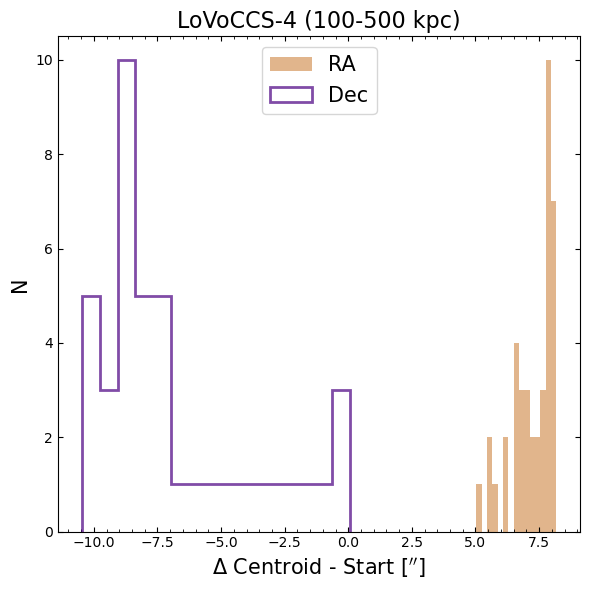

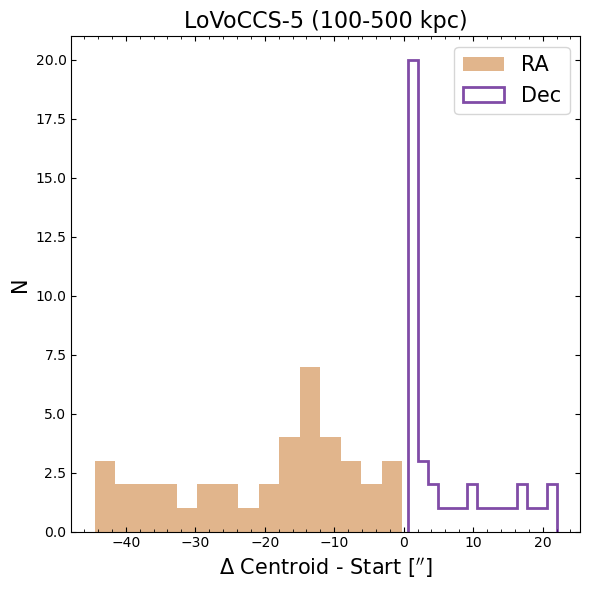

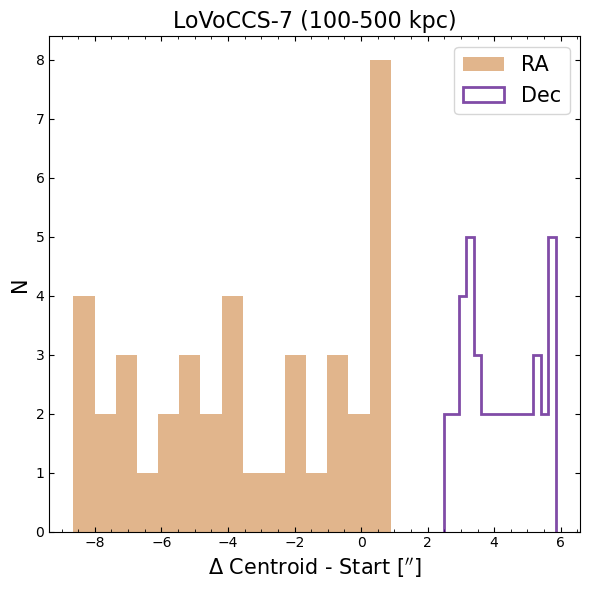

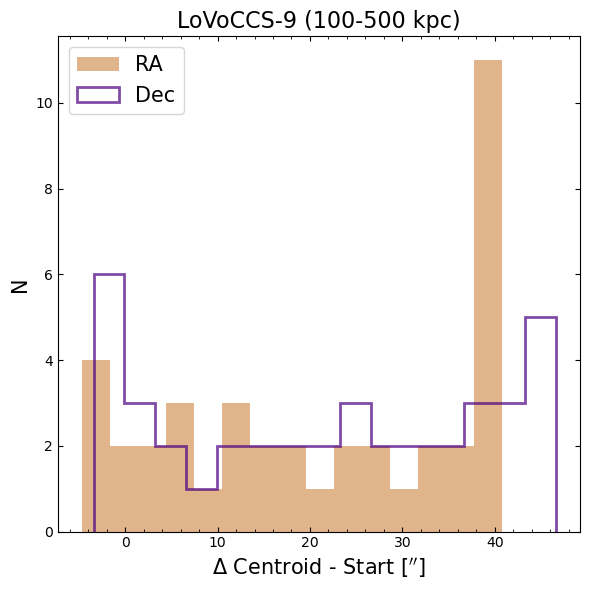

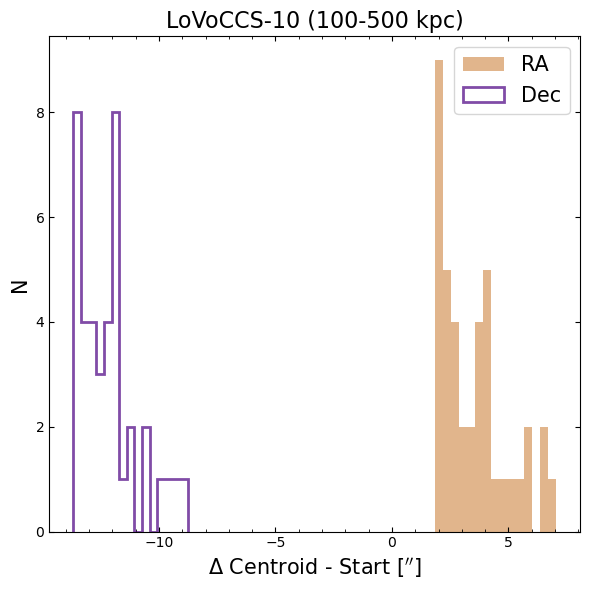

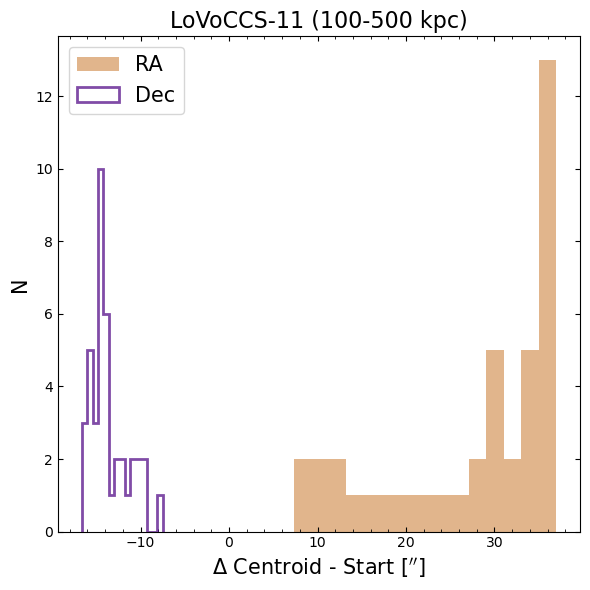

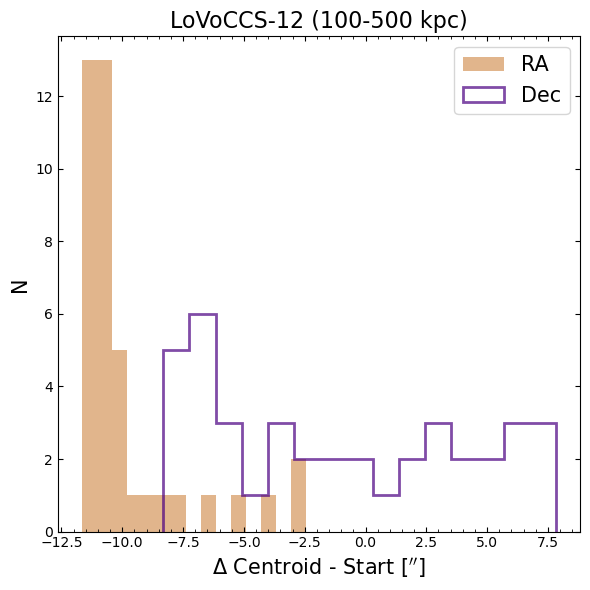

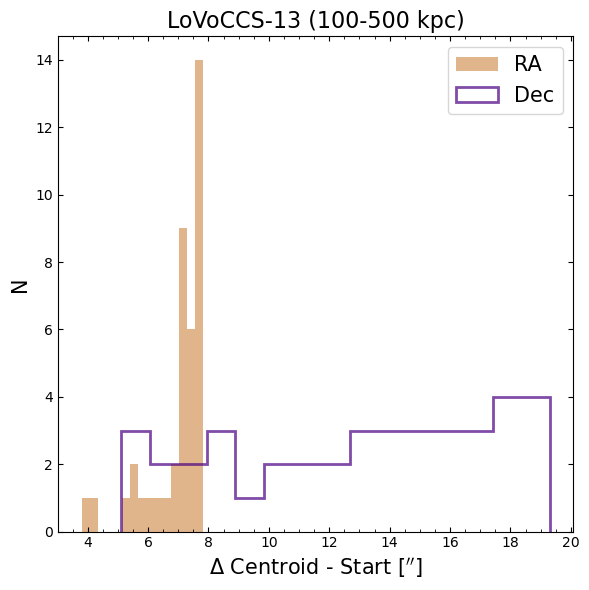

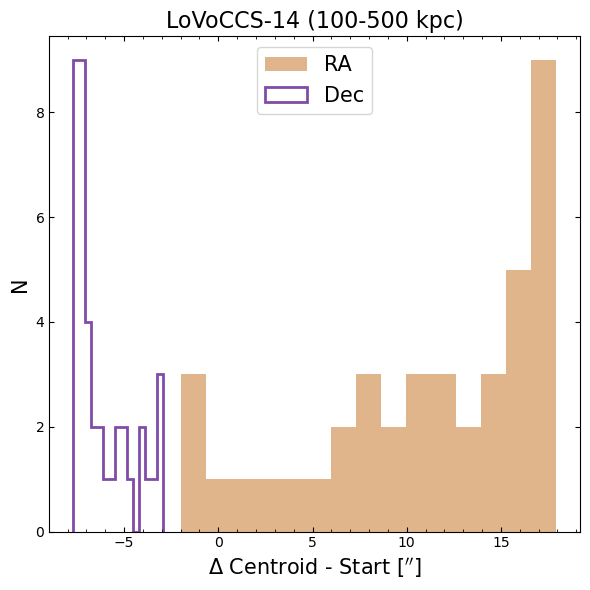

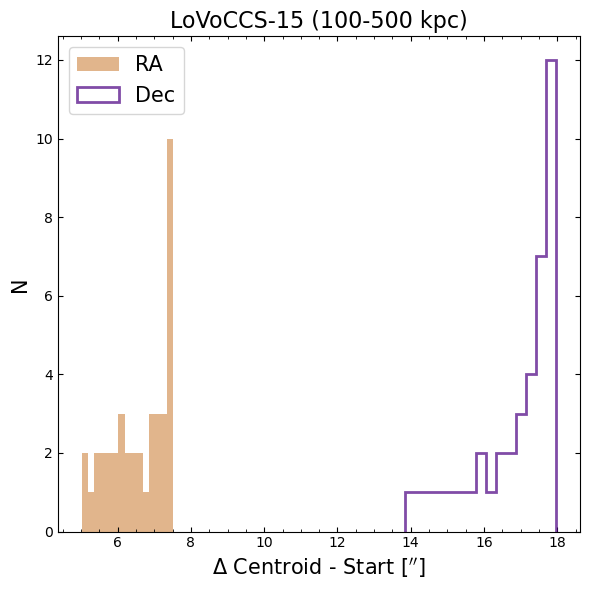

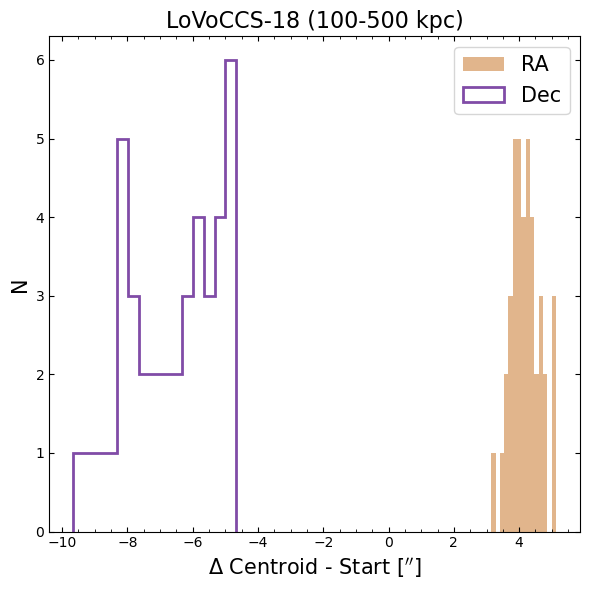

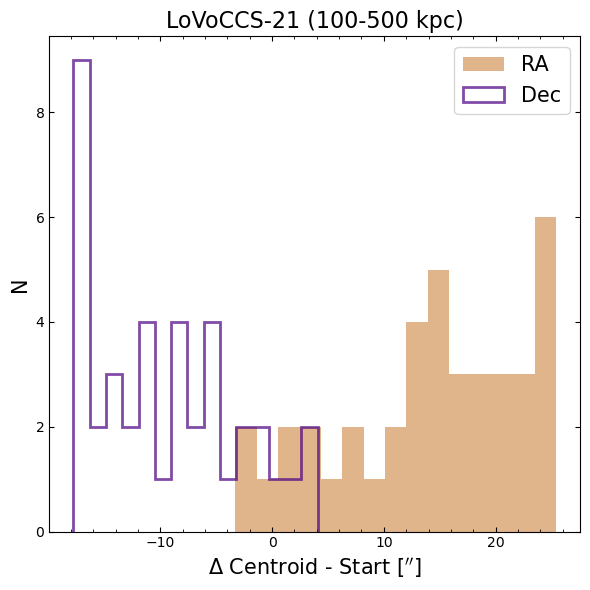

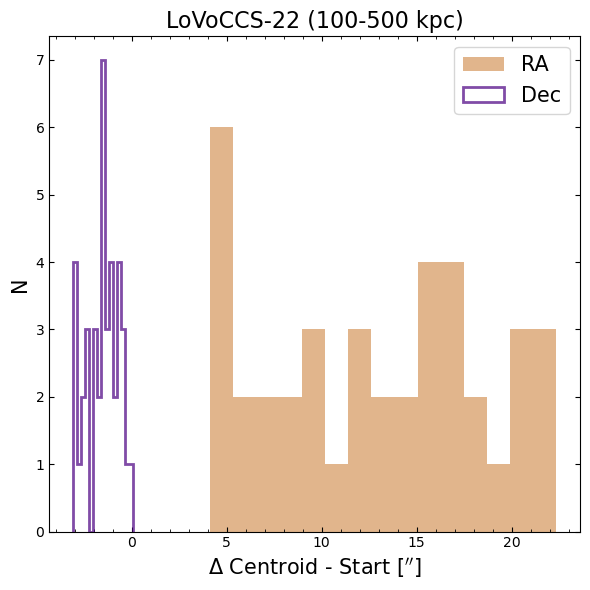

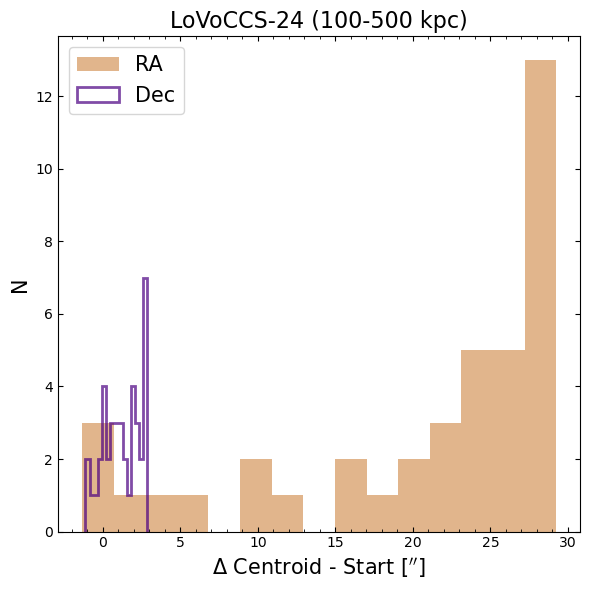

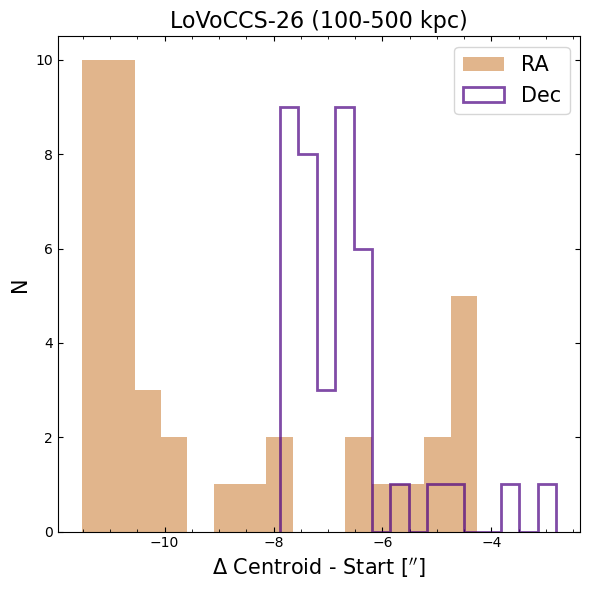

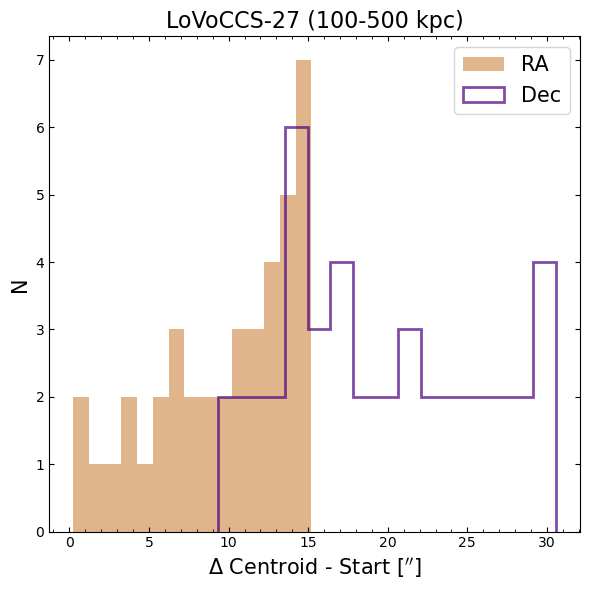

In [ ]:
cents = {}
for src in srcs:
    cents[src.name] = []
    ap_rng = Quantity(np.linspace(100, 500, 40), 'kpc')
    for ap in ap_rng:
        cur_cen, cur_ang, cur_x_scale, cur_y_scale, cur_cen_dist, cur_pa_dist, cur_x_scale_dist, \
            cur_y_scale_dist = centroid_shape_estimate(src, ap, num_samp=0)
        cents[src.name].append(cur_cen)
    
    rel_cents = Quantity(cents[src.name])
    plt.figure(figsize=(6, 6))
    
    ax = plt.gca()
    ax.minorticks_on()
    ax.tick_params(which='both', direction='in', top=True, right=True)
    ax.tick_params(which='minor', left=False, right=False)

    ax.hist((rel_cents[:, 0].value - src.ra_dec[0].value)*3600, bins=15, histtype='stepfilled', color='peru', 
            lw=2, alpha=0.6, label="RA")
    ax.hist((rel_cents[:, 1].value - src.ra_dec[1].value)*3600, bins=15, color='indigo', histtype='step', 
            alpha=0.7, label="Dec", lw=2)
    
    plt.title(src.name + " ({l}-{u} kpc)".format(l=ap_rng[0].value.astype(int), 
                                                 u=ap_rng[-1].value.astype(int)), fontsize=16)
    plt.ylabel("N", fontsize=15)
    plt.xlabel(r"$\Delta$ Centroid - Start [$^{\prime\prime}$]", fontsize=15)
    plt.legend(loc='best', fontsize=15)
    plt.tight_layout()
    
    file_name = "{n}_xmm_centroid_{l}-{u}kpc_{b}bins_dist.pdf".format(n=src.name, l=ap_rng[0].value.astype(int), 
                                                                      u=ap_rng[-1].value.astype(int), 
                                                                      b=len(ap_rng))
    plt.savefig("../../outputs/figures/positions/centroid_dists/multi_ap_centroid_dist/" + file_name)

    plt.show()
    plt.close('all')